In [1]:
import yfinance as yf
import pandas as pd
import os

In [2]:
if os.path.exists("nifty.csv"):
    nifty = pd.read_csv("nifty.csv", index_col=0)
else:
    nifty = yf.Ticker("^NSEI")
    nifty = nifty.history(period="max")
    nifty.to_csv("nifty.csv")

In [3]:
nifty.index = pd.to_datetime(nifty.index)

In [4]:
nifty

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2007-09-17 00:00:00+05:30,4518.450195,4549.049805,4482.850098,4494.649902,0,0.0,0.0
2007-09-18 00:00:00+05:30,4494.100098,4551.799805,4481.549805,4546.200195,0,0.0,0.0
2007-09-19 00:00:00+05:30,4550.250000,4739.000000,4550.250000,4732.350098,0,0.0,0.0
2007-09-20 00:00:00+05:30,4734.850098,4760.850098,4721.149902,4747.549805,0,0.0,0.0
2007-09-21 00:00:00+05:30,4752.950195,4855.700195,4733.700195,4837.549805,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-01-28 00:00:00+05:30,22960.449219,23137.949219,22857.650391,22957.250000,361900,0.0,0.0
2025-01-29 00:00:00+05:30,23026.750000,23183.349609,22976.500000,23163.099609,226300,0.0,0.0
2025-01-30 00:00:00+05:30,23169.500000,23322.050781,23139.199219,23249.500000,361900,0.0,0.0


<Axes: xlabel='Date'>

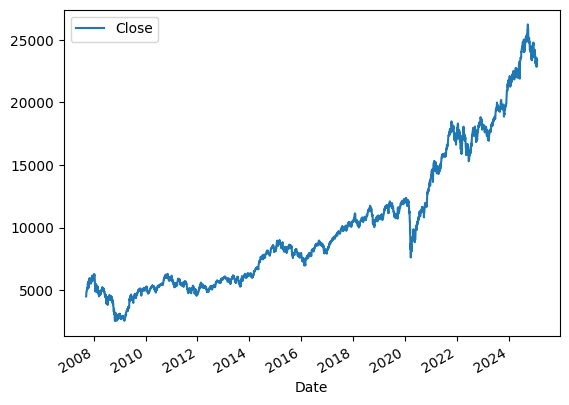

In [5]:
nifty.plot.line(y="Close", use_index=True)

In [6]:
del nifty["Dividends"]
del nifty["Stock Splits"]

In [7]:
nifty["Tomorrow"] = nifty["Close"].shift(-1)

In [8]:
nifty["Target"] = (nifty["Tomorrow"] > nifty["Close"]).astype(int)

In [9]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = nifty.iloc[:-100]
test = nifty.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [10]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.43157894736842106

<Axes: xlabel='Date'>

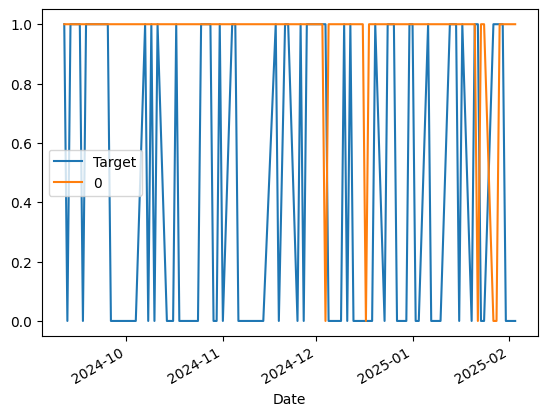

In [11]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [12]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [13]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [14]:
predictions = backtest(nifty, model, predictors)

In [15]:
predictions["Predictions"].value_counts()

Predictions
1    1001
0     761
Name: count, dtype: int64

In [16]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5394605394605395

In [17]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.547673
0    0.452327
Name: count, dtype: float64

In [18]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = nifty.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    nifty[ratio_column] = nifty["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    nifty[trend_column] = nifty.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [19]:
nifty = nifty.dropna(subset=nifty.columns[nifty.columns != "Tomorrow"])

In [20]:
nifty

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
2011-10-13 00:00:00+05:30,5130.799805,5136.950195,5067.649902,5077.850098,0,5132.299805,1,0.997883,1.0,1.014789,3.0,0.992330,23.0,0.911365,111.0,1.042939,510.0
2011-10-14 00:00:00+05:30,5057.350098,5141.399902,5056.600098,5132.299805,0,5118.250000,0,1.005333,1.0,1.015754,3.0,1.004393,24.0,0.921801,111.0,1.053995,510.0
2011-10-17 00:00:00+05:30,5156.200195,5160.200195,5084.500000,5118.250000,0,5037.500000,0,0.998629,1.0,1.007444,2.0,1.003264,23.0,0.919921,111.0,1.051026,509.0
2011-10-18 00:00:00+05:30,5049.450195,5057.500000,5011.049805,5037.500000,0,5139.149902,1,0.992049,0.0,0.989091,2.0,0.989147,23.0,0.906187,110.0,1.034383,508.0
2011-10-19 00:00:00+05:30,5080.450195,5148.049805,5075.299805,5139.149902,0,5091.899902,0,1.009989,1.0,1.007477,2.0,1.010438,24.0,0.925163,111.0,1.055190,508.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-28 00:00:00+05:30,22960.449219,23137.949219,22857.650391,22957.250000,361900,23163.099609,1,1.002798,1.0,0.996069,3.0,0.962041,27.0,0.972691,136.0,1.206393,543.0
2025-01-29 00:00:00+05:30,23026.750000,23183.349609,22976.500000,23163.099609,226300,23249.500000,1,1.004463,2.0,1.004932,3.0,0.971441,27.0,0.981129,136.0,1.216660,543.0
2025-01-30 00:00:00+05:30,23169.500000,23322.050781,23139.199219,23249.500000,361900,23508.400391,1,1.001862,2.0,1.008295,3.0,0.975573,28.0,0.984472,137.0,1.220642,543.0


In [21]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [22]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [23]:
predictions = backtest(nifty, model, new_predictors)

In [24]:
predictions["Predictions"].value_counts()

Predictions
0.0    696
1.0     66
Name: count, dtype: int64

In [25]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5606060606060606

In [26]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.53937
0    0.46063
Name: count, dtype: float64

In [27]:
predictions

,Target,Predictions
Date,,
2022-01-04 00:00:00+05:30,1,0.0
2022-01-05 00:00:00+05:30,0,0.0
2022-01-06 00:00:00+05:30,1,0.0
2022-01-07 00:00:00+05:30,1,0.0
2022-01-10 00:00:00+05:30,1,1.0
...,...,...
2025-01-28 00:00:00+05:30,1,0.0
2025-01-29 00:00:00+05:30,1,1.0
2025-01-30 00:00:00+05:30,1,0.0
